In [6]:
from dasquakes import *
import pickle
import datetime

# Make an fk plot

In [7]:
t0 = datetime.datetime(2022, 12, 1, 0, 0, 0)

# ft,f,k = fk_analysis(t0=t0,
#                  record_length=60,
#                  cable='whidbey'
#                  )

# pickle.dump({'ft':ft,'f':f,'k':k}, open('fk-1hr.pkl', 'wb'), protocol=4)

In [8]:
data_dict = pickle.load(open('fk-1hr.pkl', 'rb'))
ft = data_dict['ft']
f = data_dict['f']
k = data_dict['k']

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

kk,ff = np.meshgrid(k,f)
f0 = 0.02
n = 1
filt = np.abs(ff/f0)**n/(1 + np.abs(ff/f0)**n )

the_goods = np.log10(np.abs(ft)).astype(float)

# Pull one minute of raw data

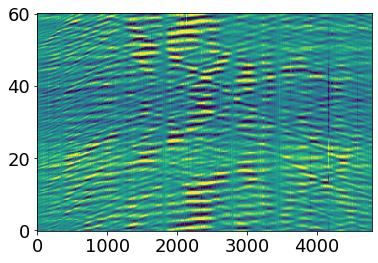

In [9]:
import xarray as xr

cable='whidbey'
record_length = 1 #minutes
prefix, network_name, datastore = data_wrangler(cable,record_length,t0)

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=False)

plt.subplots()
i1 = 2450
i2 = 3200
t = np.linspace(0,60,240)
x = np.array(range(i2-i1)) * 6.38
data_subset = data[::25,i1:i2]

plt.pcolor(x,t,data_subset,vmin=-1,vmax=1)
plt.show()


data_xr = xr.DataArray(data_subset.T, coords=(x,t))

fk = xr.DataArray(the_goods.T, coords=(k,f))
fk = fk.transpose()

# Plot the data together with a map

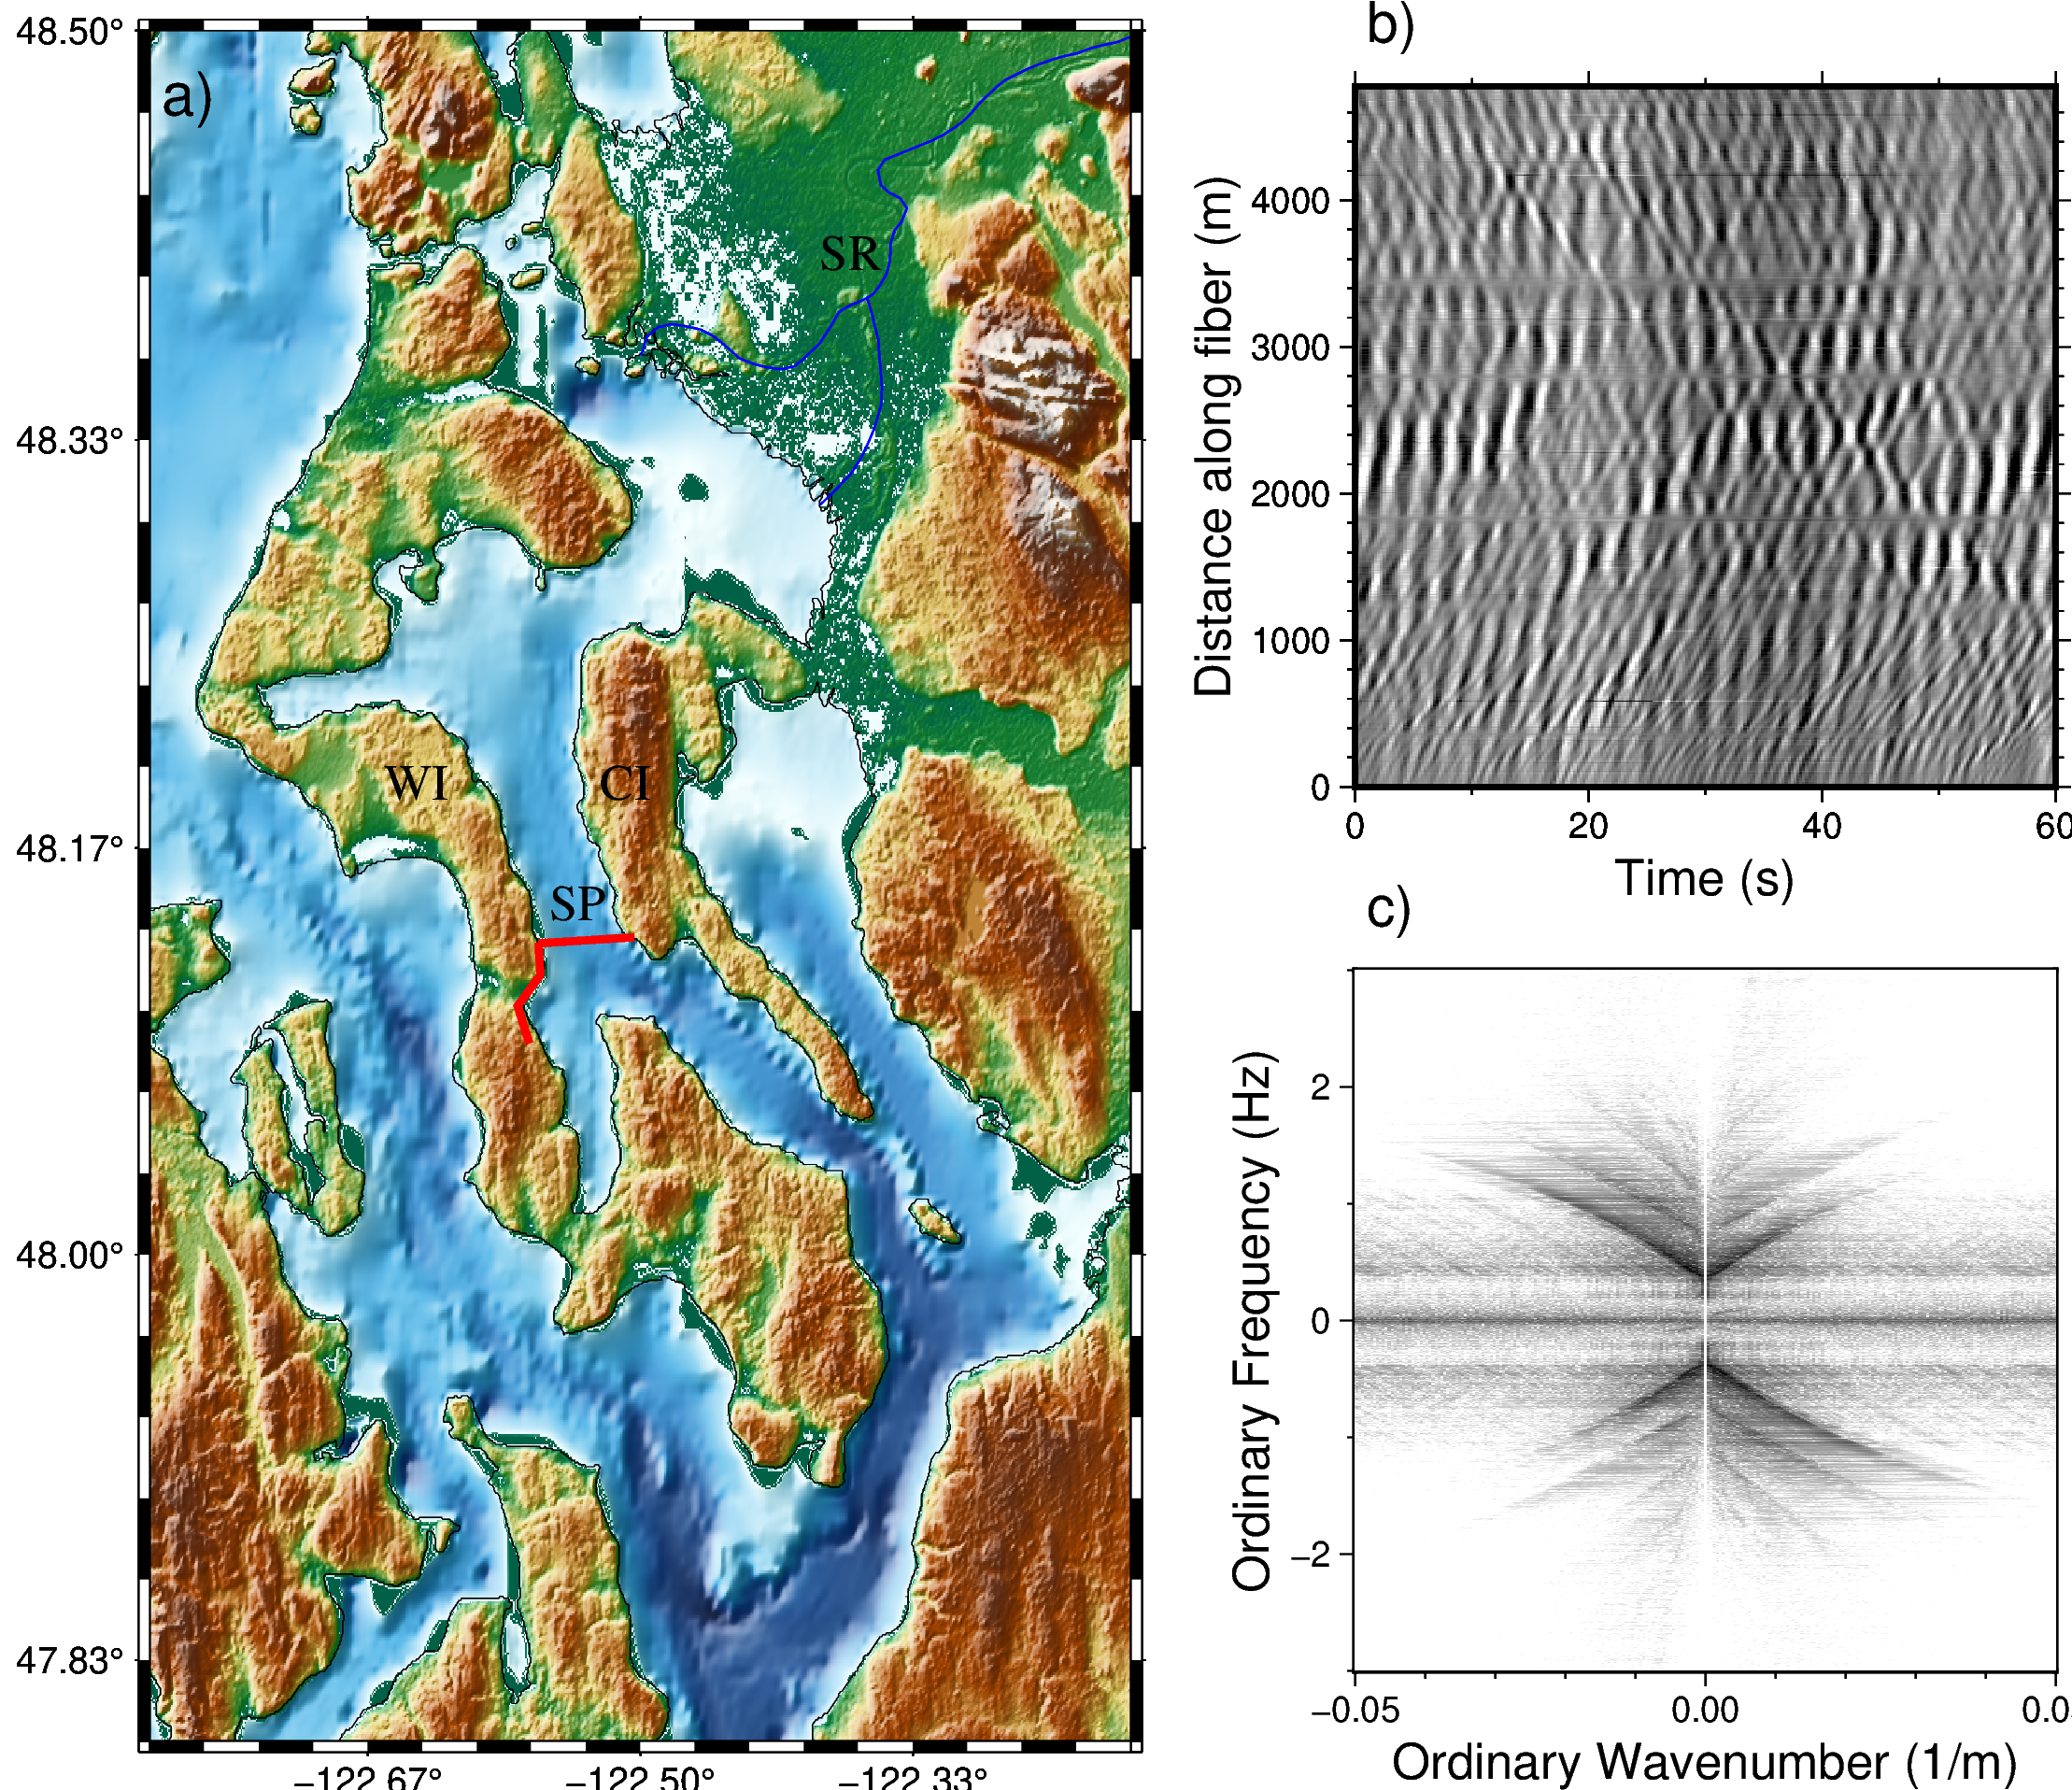

In [47]:
topo_data = '@earth_relief_03s' #3 arc second global relief (SRTM3S)

import pygmt
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.xx")

with fig.subplot(nrows=1, ncols=1, figsize=("5i", "6i"), autolabel="a)"):
    
    minlon, maxlon = -122.8, -122.2
    minlat, maxlat = 47.8, 48.5
    reg = [minlon, maxlon, minlat, maxlat]
    prj = 'M3.5i'

    fig.basemap(region=reg,projection=prj)
    
    fig.grdimage(
        grid=topo_data,
        region=reg,
        projection=prj,
        shading=True
        )

    fig.coast(
        region=reg,
        projection=prj,
        shorelines=True,
        frame=True,
        rivers="a/0.5p,blue,solid"
        )

    fig.plot(
        region=reg,
        projection=prj,
        x=[-122.562266,-122.561251, -122.575092,  -122.568056],
        y=[48.127646, 48.114600, 48.102011,   48.0867],
        pen="2p,red",
    )
    
     


    fig.plot(
        region=reg,
        projection=prj,
        x=[-122.562266, -122.503804],
        y=[48.127646, 48.130110],
        pen="2p,red",
    )
    
    fig.text(text="CI", x=-122.64, y=48.2, font="13p,Times-Roman,black")
    fig.text(text="WI", x=-122.77, y=48.2, font="13p,Times-Roman,black")
    fig.text(text="SR", x=-122.5, y=48.42, font="13p,Times-Roman,black")
    fig.text(text="SP", x=-122.67, y=48.15, font="13p,Times-Roman,black")
    
fig.shift_origin(xshift="4.3i",yshift="0.25i")

    
# Bottom row, two subplots
with fig.subplot(nrows=2, ncols=1, figsize=("3i", "6i"), autolabel="b)"):
    reg = [0, 60,min(x), max(x)]
    prj = "X2.5i"
    fig.basemap(
        region=reg, projection=prj, frame=["af", "WSne"], panel=[0, 0]
    )

    pygmt.makecpt(cmap='gray',series='-1/1/0.1',continuous=True)
    fig.grdimage(data_xr,region=reg,projection=prj,frame=True)
    fig.basemap(
        region=reg,
        projection=prj,
        # Plot axis, tick marks, and axis labels on the west/left and south/bottom axes
        # Plot axis and tick marks on the north/top and east/right axes
        frame=[ "yaf+lDistance along fiber (m)", "xaf+lTime (s)"],
    )
    
    
    # FK Plot
    prj = "X2.5i"
    reg = [-0.05, 0.05, -3, 3]
    fig.basemap(
        region=reg, projection=prj, frame=["xaf+lOrdinary Wavenumber (1/m)", "yaf+lOrdinary Frequency (Hz)"], 
        panel=[1, 0]
    )
    pygmt.makecpt(cmap='grayC',series='2/5/0.1',continuous=True)
    fig.grdimage(fk,region=reg,projection=prj)

fig.savefig("combo.png")
fig.show()

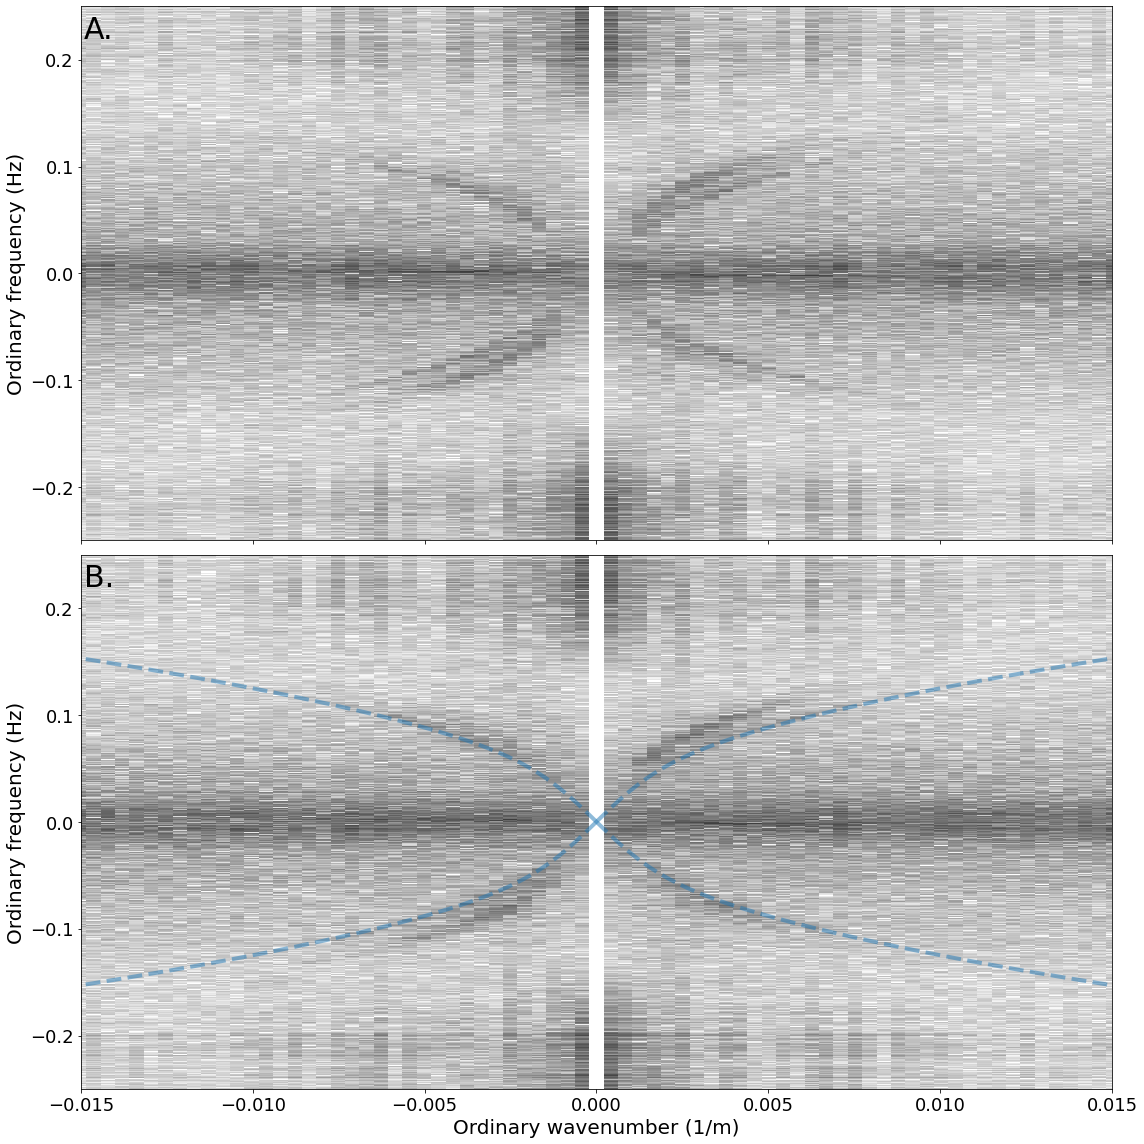

In [66]:
kk = np.linspace(0,0.015,100)
k_angular = 2*np.pi*kk
h = 100
g=9.8
omega = np.sqrt( k_angular*g*np.tanh(k_angular*h) ) / np.pi/2

plt.subplots(2,1,figsize=(16,16),sharex=True)
plt.subplot(2,1,1)
plt.pcolormesh(k,f[np.abs(f)<0.25],the_goods[np.abs(f)<0.25,:],cmap='Greys',vmin=1.5,vmax=5)
plt.xlim([-0.015,0.015])
# plt.xlabel('Ordinary wavenumber (1/m)',fontsize=20)
plt.ylabel('Ordinary frequency (Hz)',fontsize=20)
plt.text(-0.0149,0.22,'A.',fontsize=30)

plt.subplot(2,1,2)
plt.pcolormesh(k,f[np.abs(f)<0.25],the_goods[np.abs(f)<0.25,:],cmap='Greys',vmin=1.5,vmax=5)
plt.plot(kk,omega,'--',c='C0',alpha=0.5,linewidth=4)
plt.plot(kk,-omega,'--',c='C0',alpha=0.5,linewidth=4)
plt.plot(-kk,omega,'--',c='C0',alpha=0.5,linewidth=4)
plt.plot(-kk,-omega,'--',c='C0',alpha=0.5,linewidth=4)
plt.text(-0.0149,0.22,'B.',fontsize=30)

plt.xlim([-0.015,0.015])
plt.xlabel('Ordinary wavenumber (1/m)',fontsize=20)
plt.ylabel('Ordinary frequency (Hz)',fontsize=20)

plt.tight_layout()
plt.show()

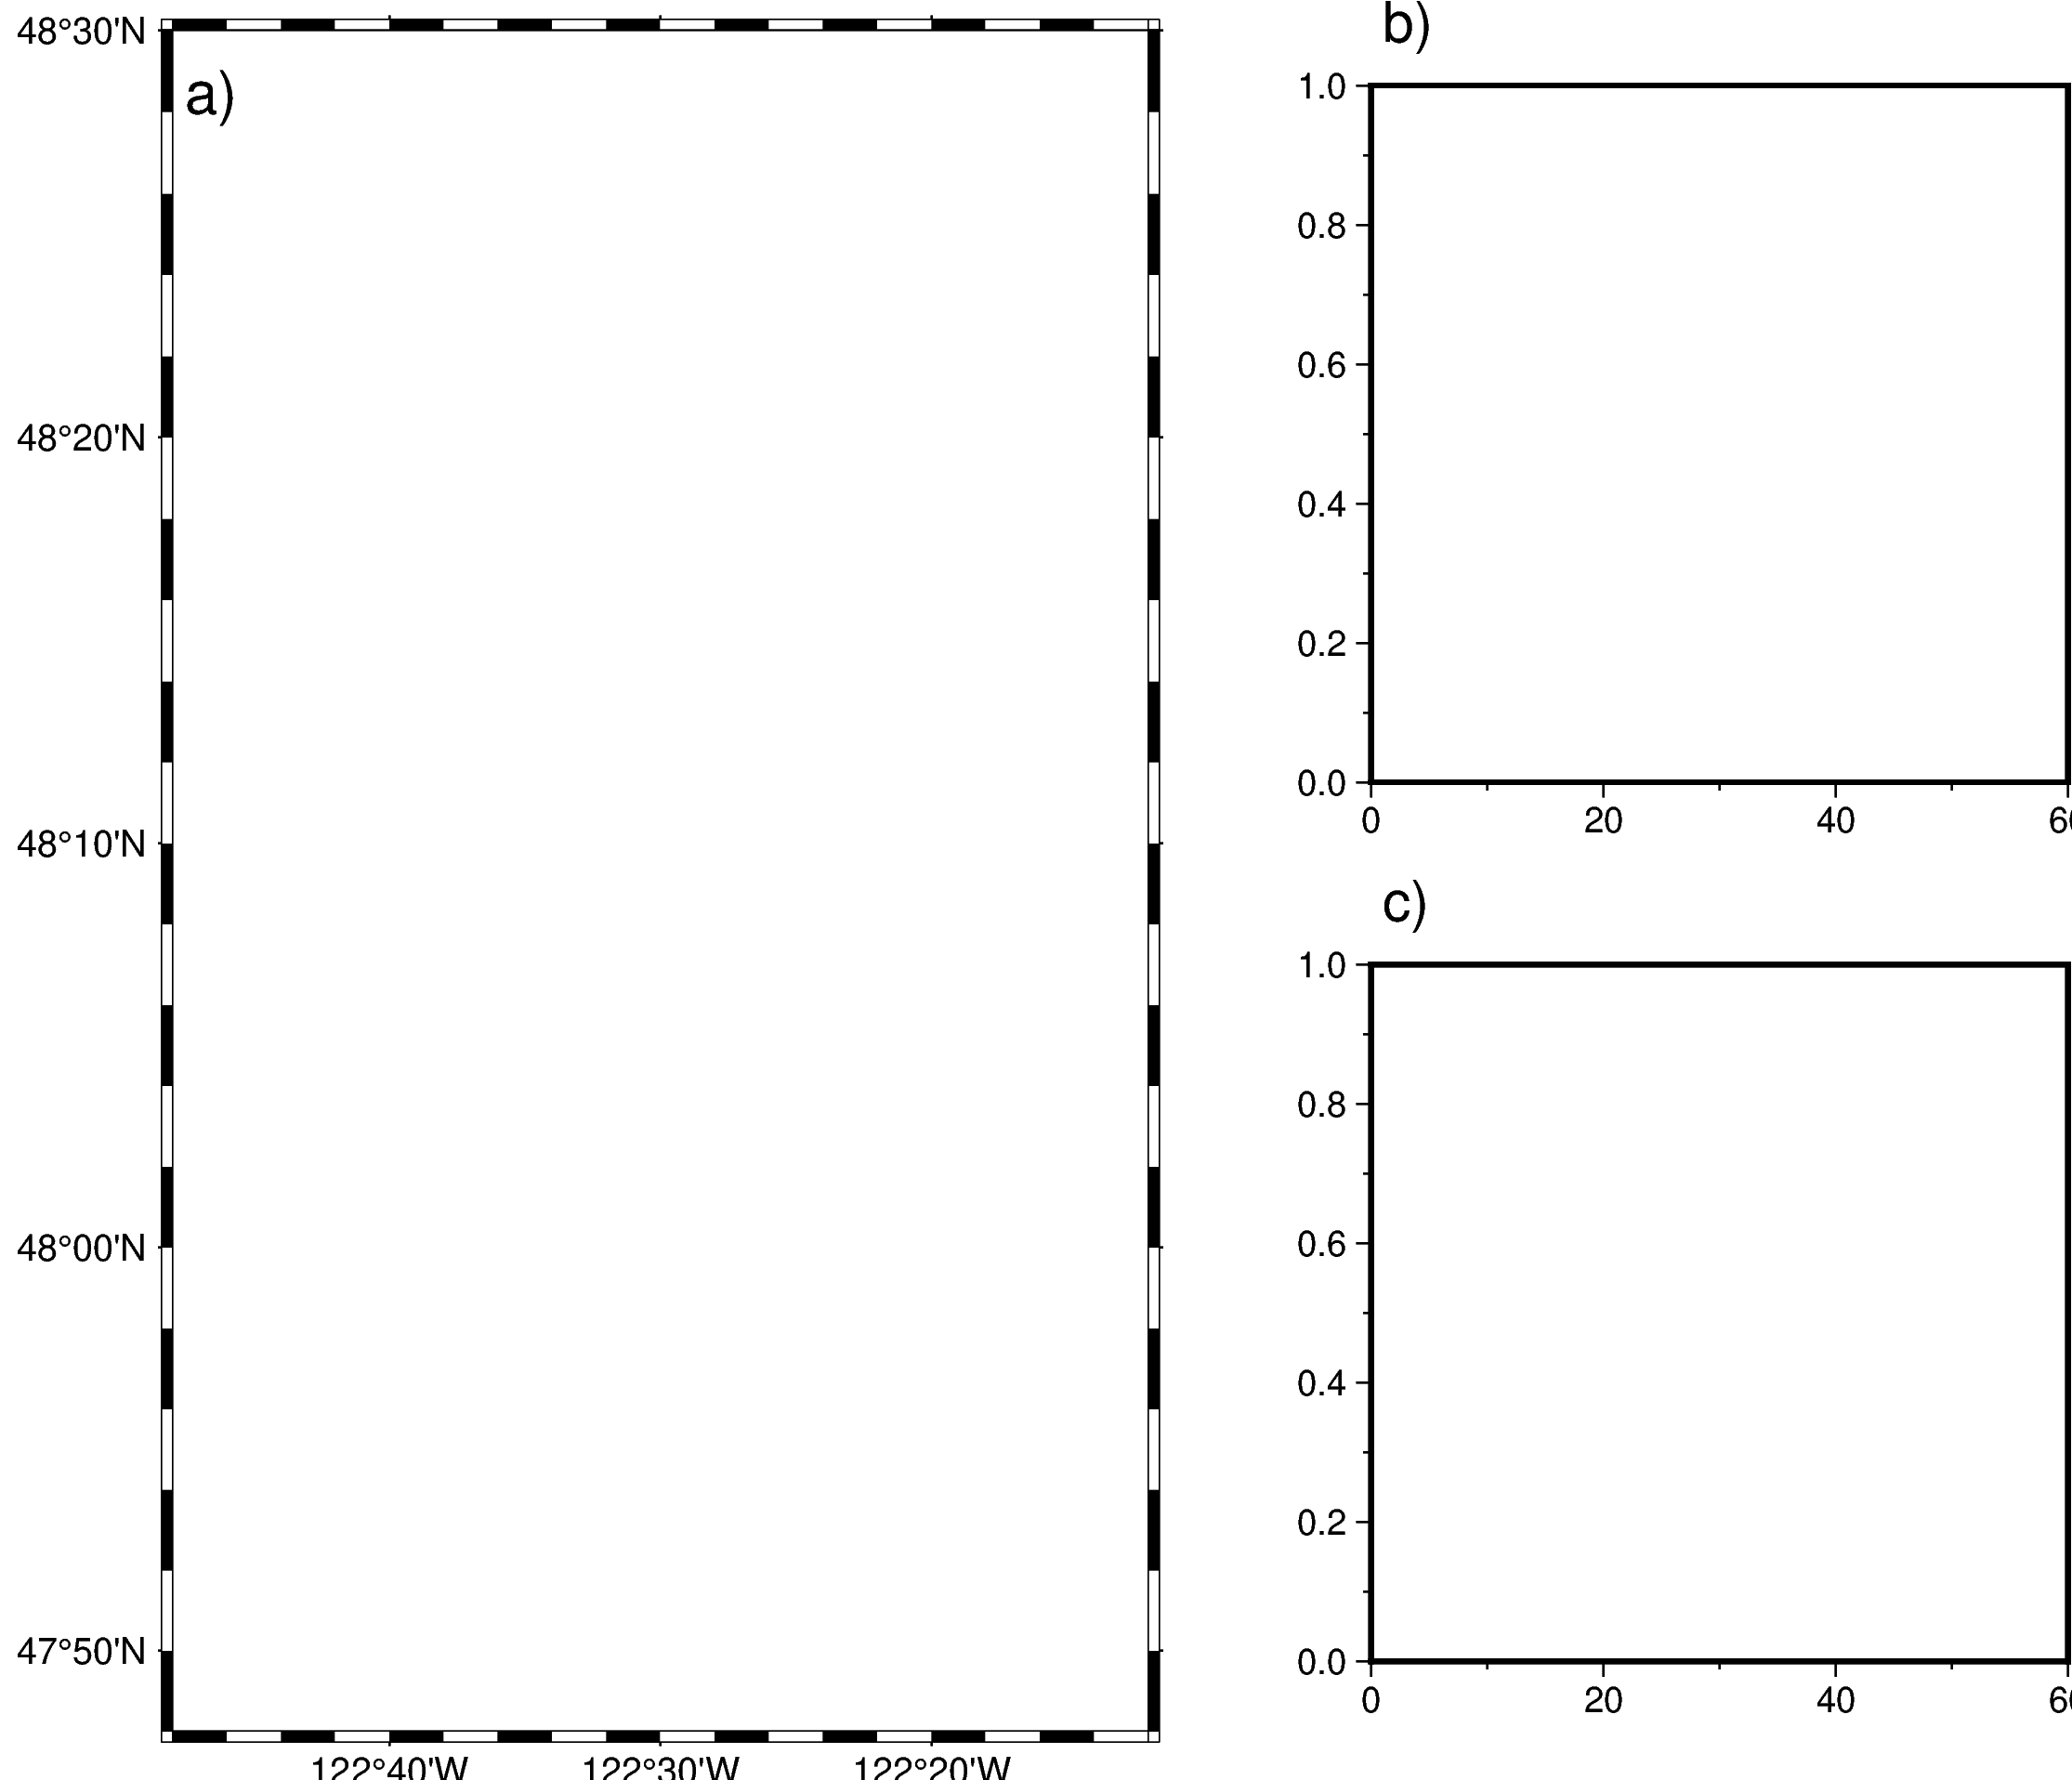

In [55]:
import pygmt
fig = pygmt.Figure()

with fig.subplot(nrows=1, ncols=1, figsize=("5i", "6i"), autolabel="a)"):
    fig.basemap(region=[-122.8, -122.2, 47.8, 48.5],projection='M3.5i')
    
fig.shift_origin(xshift="4.3i",yshift="0.25i")

with fig.subplot(nrows=2, ncols=1, figsize=("3i", "6i"), autolabel="b)"):
    fig.basemap(region=[0, 60,0, 1], projection="X2.5i")
    fig.basemap(region=[0, 60,0, 1], projection="X2.5i", panel=[1, 0])
fig.savefig('problem.png')
fig.show()